<a href="https://colab.research.google.com/github/tnusser/SensorimotorClassifier/blob/master/SensorimotorClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bert-embedding

In [81]:
import csv
import pandas as pd
import numpy as np
import ast

import gzip
import shutil

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from bert_embedding import BertEmbedding

In [2]:
def parse_to_dict(file_path):
    """
    Creates hashmap with word as key and concept vector as value
    :param file_path: path to the conceptnet dictionary file
    :return: hashmap of word and vectors
    """
    concept_hash = {}
    with open(file_path, encoding="utf8") as f:
        text = f.readlines()[1:]
        for line in text:
            first_item = line.split(" ").__getitem__(0)
            concept_hash[first_item] = line
    f.close()
    return concept_hash

def find_word(embedding, word, dictionary, mode=None):
    """
    Finds embedding vector for a word in the conceptnet hashmap
    :param word: input word to analyze
    :param concept_hash: hashmap of word and conceptnet vector
    :return: returns the appropriate vector or none if its not in the hashmap
    """
    if embedding == "conceptnet":
      if word in dictionary.keys():
          vector = dictionary[word].split(" ")[1:]
          vector = [float(i) for i in vector]
      else:
          vector = []
    if embedding == "bert":
      bert_vec = bert_embedding([word])[0][1]
      if mode == "add":
        vector = np.asarray([sum(x) for x in zip(*bert_vec)])
    return vector

def from_np_array(array_string):
    """
    Converts string array from imported csv to an actual
    numpy array
    :array_string input string which can be represented as np array
    """
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [3]:
# Sensorimotor Dataset
!wget -O "data.csv" "https://osf.io/48wsc/download"

# ConceptNet Word Embeddings
!wget https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-en-19.08.txt.gz

--2020-08-14 08:36:15--  https://osf.io/48wsc/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.de-1.osf.io/v1/resources/rwhs6/providers/osfstorage/5cc2d6441906ec0017056ba8?action=download&direct&version=1 [following]
--2020-08-14 08:36:15--  https://files.de-1.osf.io/v1/resources/rwhs6/providers/osfstorage/5cc2d6441906ec0017056ba8?action=download&direct&version=1
Resolving files.de-1.osf.io (files.de-1.osf.io)... 35.186.249.111
Connecting to files.de-1.osf.io (files.de-1.osf.io)|35.186.249.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17196336 (16M) [text/csv]
Saving to: ‘data.csv’

data.csv            100%[===================>]  16.40M  10.4MB/s    in 1.6s    

2020-08-14 08:36:19 (10.4 MB/s) - ‘data.csv’ saved [17196336/17196336]

--2020-08-14 08:36:19--  https://conceptnet.s3.amazonaws.com/downloads/2019/numberbat

In [6]:
with gzip.open("numberbatch-en-19.08.txt.gz",'rb') as f_in:
    with open('numberbatch-en.txt','wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
concept_hash = parse_to_dict("numberbatch-en.txt")

In [5]:
df = pd.read_csv("data.csv", usecols=["Word", "Auditory.mean", "Gustatory.mean", "Haptic.mean", "Interoceptive.mean", "Olfactory.mean", "Visual.mean"])
df.columns = ["word", "auditory", "gustatory", "haptic", "interoceptive", "olfactory", "visual"]
df["word"] = df["word"].str.lower()
df['word'] = df['word'].str.replace(' ','_')
df.head()

,word,auditory,gustatory,haptic,interoceptive,olfactory,visual
0,A,2.214286,0.000000,0.428571,0.000000,0.000000,2.428571
1,A CAPPELLA,4.333333,0.000000,0.222222,0.722222,0.000000,1.666667
2,AARDVARK,1.625000,0.562500,1.625000,0.062500,1.250000,4.125000
3,ABACK,1.294118,0.058824,0.294118,1.352941,0.000000,2.823529
4,ABACUS,1.555556,0.166667,3.722222,0.277778,0.111111,3.944444


In [6]:
vecs = []
df["max_val"] = df.iloc[:,1:7].idxmax(axis=1)
for index, row in df.iterrows():
    word_vec = find_word(embedding="conceptnet", word=row['word'], dictionary=concept_hash)
    if word_vec == None:
        df.drop(index, inplace=True)
    else:
        vecs.append(word_vec)
df["vec"] = vecs
df.head()

In [4]:
bert_embedding = BertEmbedding()

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/utils.py:331: UserWarning: File /root/.mxnet/models/bert_12_768_12_book_corpus_wiki_en_uncased-75cc780f.zip exists in file system so the downloaded file is deleted
  'File {} exists in file system so the downloaded file is deleted'.format(fname))


In [5]:
df_bert = pd.read_csv("data.csv", usecols=["Word", "Auditory.mean", "Gustatory.mean", "Haptic.mean", "Interoceptive.mean", "Olfactory.mean", "Visual.mean"])
df_bert.columns = ["word", "auditory", "gustatory", "haptic", "interoceptive", "olfactory", "visual"]
vecs = []
df_bert["max_val"] = df_bert.iloc[:,1:7].idxmax(axis=1)
for index, row in df_bert.iterrows():
    word_vec = find_word(embedding="bert", word=row["word"], dictionary=None, mode="add")
    if len(word_vec) < 1:
        df_bert.drop(index, inplace=True)
    else:
        vecs.append(word_vec)
    if index % 1000 == 0:
      print(index)

df_bert["vec"] = vecs
df_bert.head()
df_bert.to_csv("output")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000


In [7]:
from google.colab import files
files.download('output') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
df_temp = pd.read_csv("output")
print("Convert . . .")
df_temp.vec = df_temp.vec.apply(lambda x: from_np_array(x))
df_temp.vec[0].shape

Convert . . .


(768,)

In [41]:
np.asarray(bert_embedding([df_bert.word[1]])[0][1]).shape

(2, 768)

In [8]:
 X_train, X_test, y_train, y_test = train_test_split(np.stack(df_temp.vec, axis=0), df.max_val, test_size=0.2, random_state=43)

In [82]:
gnb = GaussianNB()
neigh = KNeighborsClassifier(n_neighbors=3)
clf = GradientBoostingClassifier(random_state=0, verbose=1)
lgr = LogisticRegression(random_state=0, verbose=1)
dtc = DecisionTreeClassifier(random_state=1)
svm_model = svm.SVC()

In [67]:
from sklearn.metrics import precision_recall_fscore_support as score
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     auditory       0.23      0.24      0.23       949
    gustatory       0.17      0.15      0.16       192
       haptic       0.05      0.06      0.05       189
interoceptive       0.21      0.21      0.21       718
    olfactory       0.02      0.02      0.02        43
       visual       0.77      0.75      0.76      5851

     accuracy                           0.61      7942
    macro avg       0.24      0.24      0.24      7942
 weighted avg       0.62      0.61      0.61      7942



In [ ]:
y_pred = svm_model.fit(X_train, y_train).predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred, average="weighted")

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

In [13]:
 xtrain, xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.1, random_state=43)

In [26]:
ytrain_hot = pd.get_dummies(ytrain)
yval_hot = pd.get_dummies(yval)

In [69]:
model = models.Sequential()
model.add(layers.Dense(768, activation='relu' ,input_shape=(768,)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['acc'])
print(model.summary())
filepath="weights.best.hdf5"
history = model.fit(xtrain,
                    ytrain_hot,
                    epochs=12,
                    batch_size=512,
                    validation_data=(xval, yval_hot), verbose=1)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 768)               590592    
_________________________________________________________________
dense_41 (Dense)             (None, 256)               196864    
_________________________________________________________________
dense_42 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_43 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_44 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_45 (Dense)             (None, 6)                 198       
Total params: 830,886
Trainable params: 830,886
Non-trainable params: 0
_______________________________________________

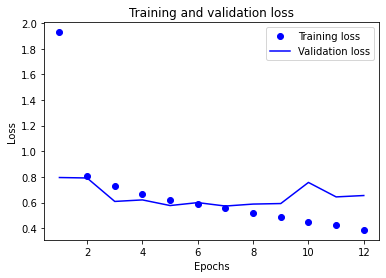

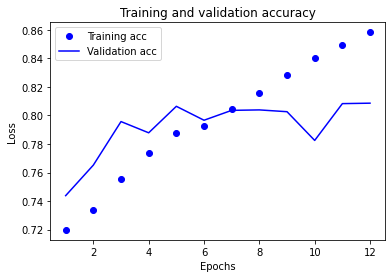

In [70]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [72]:
y_pred = model.predict(X_test)

In [60]:
labels = ["auditory", "gustatory", "haptic", "interoceptive", "olfactory", "visual"]

In [73]:
print(y_pred)
y_test_hot = pd.get_dummies(y_test)

tp, fp = 0,0
for i, pred in enumerate(y_pred):
  if labels[np.argmax(pred)] == np.asarray(y_test)[i]:
    tp += 1
  else:
    fp += 1

print(tp/len(y_test))


[[3.88522691e-04 1.20525665e-05 1.39502706e-02 1.02894916e-03
  2.23781808e-05 9.84597802e-01]
 [3.09664616e-03 6.60704775e-03 9.25345998e-03 7.61509780e-03
  2.09150254e-03 9.71336186e-01]
 [1.85724813e-02 3.32355557e-06 6.27076370e-04 2.44183093e-03
  4.45612068e-06 9.78350818e-01]
 ...
 [1.42115052e-04 8.85919784e-04 1.00160465e-02 1.15971459e-04
  3.39853019e-02 9.54854608e-01]
 [2.11708751e-02 1.39271119e-03 2.70917229e-02 4.69053015e-02
  9.40549071e-04 9.02498901e-01]
 [2.24405080e-01 8.11564605e-05 7.67090125e-04 1.04078092e-02
  8.88421855e-05 7.64250040e-01]]
0.7907328128934777
